<a href="https://colab.research.google.com/github/rcurrie/pancan-gtex/blob/master/infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import sys
import os
import json
import requests
import numpy as np
import pandas as pd
!pip install -q tables
import tensorflow as tf
from IPython.core.display import display, HTML

def log(text):
    # Print to notebook and console so we can see in k8s logging
    print(text)
    sys.__stdout__.write(text + "\n")
    sys.__stdout__.flush()
    
# Syntatic sugar for debug vs. train parameters
def debug(debug_param, no_debug_param):
    return debug_param if os.environ.get("DEBUG") == "True" else no_debug_param
log(debug("DEBUG: ON", "DEBUG: OFF"))

# Create and switch to a scratch data directory so all paths are local
os.chdir(os.path.expanduser("~/data/treehouse"))

DEBUG: ON


In [101]:
# Load params and model
with open("params.json") as f:  
    params = json.load(f)

model = tf.keras.models.load_model("model.h5")

# Load dataset for SHAP explanations background
X = pd.read_hdf("treehouse-pruned.h5", "samples")
Y = pd.read_hdf("treehouse-pruned.h5", "labels")

## Prediction

In [103]:
# Load full original samples and extract the N of 1 - Alternately load the RSEM output of a new sample
all_samples = pd.read_hdf("treehouse.T.fp32.h5")

In [104]:
focus_sample_features = all_samples.loc["TH03_0115_S01"].apply(np.exp2).subtract(1.0).clip(lower=0.0)

# Prune down to genes we trained on and reshape for keras prediction
focus_sample_features = focus_sample_features.drop(set(all_samples.loc["TH03_0115_S01"].index) - set(X.columns.values))
focus_sample_features = focus_sample_features.values.reshape(1,-1)

In [106]:
# predict processes multiple samples and returns a list of predictions
# We just have one so take the first
prediction = model.predict(focus_sample_features)[0]

disease_prediction_index = np.argmax(prediction)
disease_prediction_value = prediction[disease_prediction_index]
disease_prediction_label = params["disease"][disease_prediction_index]
display(HTML("<h3>{} ({:.2f})</h3>".format(
    disease_prediction_label.capitalize(), disease_prediction_value)))

## Explanation 

In [107]:
import shap
shap.initjs()

# Select a set of background samples of the same disease to take an expectation over
Y_background = Y[Y.disease == disease_prediction_label]
X_background = X.loc[Y_background.index]
print("Found {} {} training samples".format(X_background.shape[0], disease_prediction_label))

Found 606 glioma training samples


In [111]:
%%time
np.random.seed(42)
background = X_background.iloc[np.random.choice(X_background.shape[0], debug(20, 100), replace=False)]
print("Randomly selecting {} out of {} {} samples as background to compute an expectatin over".format(
    background.shape[0], X_background.shape[0], disease_prediction_label))
explainer = shap.DeepExplainer(model, background)

Randomly selecting 20 out of 606 glioma samples as background to compute an expectatin over
CPU times: user 51.6 ms, sys: 25.7 ms, total: 77.3 ms
Wall time: 58.8 ms


In [112]:
%%time
# Explain predictions of model for our focus sample
sample_shap_values = explainer.shap_values(focus_sample_features)

CPU times: user 1min 46s, sys: 4.97 s, total: 1min 51s
Wall time: 1min 50s


### Genes driving focus sample disease classification

In [124]:
shap.force_plot(
    base_value=explainer.expected_value[disease_prediction_index],
    shap_values=sample_shap_values[disease_prediction_index], 
    features=sample_features, 
    feature_names=X_background.columns.values,
    link="identity")

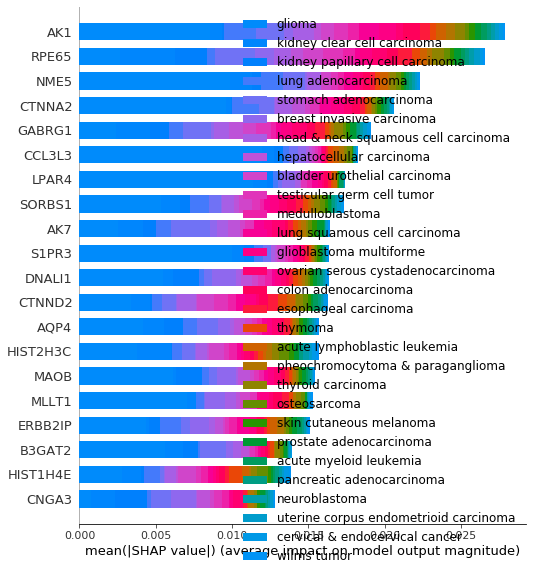

In [133]:
# shap.summary_plot(sample_shap_values, background, max_display=7, class_names=params["disease"])

shap.summary_plot(
    shap_values=sample_shap_values, 
    features=sample_features, 
    feature_names=X_background.columns.values,
    class_names=params["disease"],
    max_display=20, plot_type="violin")

### Enrished pathway identifation from SHAP values
(not complete)
https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-11-574

In [135]:
max_display = 10
feature_order = np.argsort(np.sum(np.mean(np.abs(sample_shap_values), axis=0), axis=0))
# feature_order = np.argsort(abs(sample_shap_values[disease_prediction_index][0]))
feature_order = feature_order[-min(max_display, len(feature_order)):]
print("Top gene's driving disease prediction")
print([X.columns.values[i] for i in feature_order])

Top gene's driving disease prediction
['S1PR3', 'AK7', 'SORBS1', 'LPAR4', 'CCL3L3', 'GABRG1', 'CTNNA2', 'NME5', 'RPE65', 'AK1']


In [154]:
background.iloc[0:5,:].shape

(5, 5545)

In [157]:
%%time
# Explain predictions of model for all background samples
background_shap_values = explainer.shap_values(background.values)

CPU times: user 29min 4s, sys: 32.9 s, total: 29min 37s
Wall time: 29min 8s


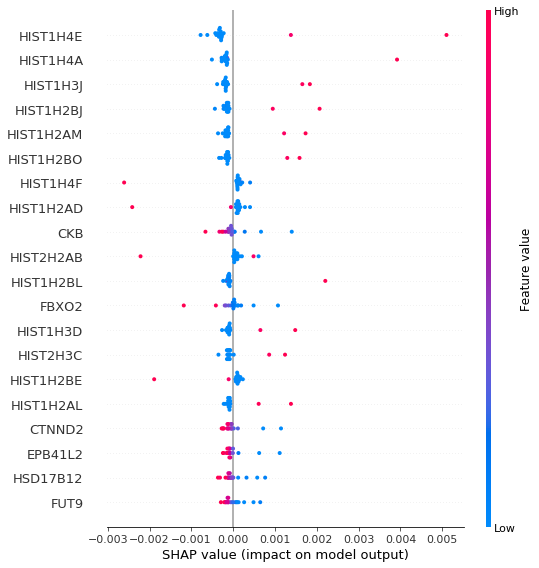

In [160]:
shap.summary_plot(background_shap_values[0], background, plot_type='dot')

### Genes driving disease classification for all background samples

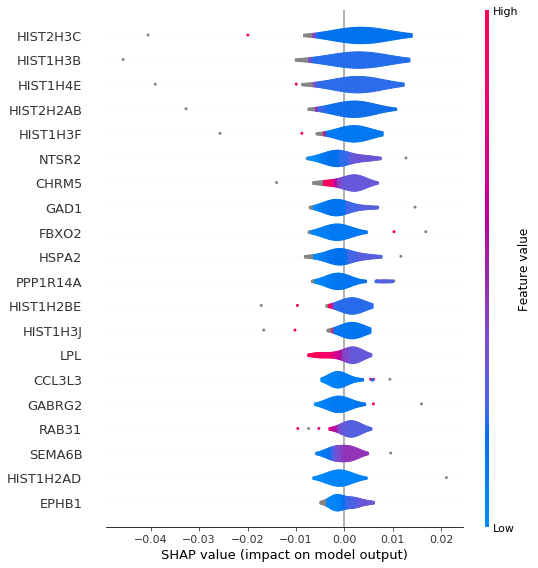

In [163]:
shap.summary_plot(background_shap_values[disease_prediction_index], background, plot_type="violin")

## Most Similar Samples
List closest by spearman distance samples from PanCan along with their relevant prognostic endpoints (OSS etc...)

In [165]:
import scipy
import sklearn.metrics.pairwise as sklp

def nearest_samples(cohort, sample, N=-1):
    """
    Compute the Spearman distance between sample and every member of the
    cohort and return the N nearest samples from the cohort.

    cohort, sample: Pandas data frames with columns=features/genes
    N: the number of most similar samples to return
    """
    # Column wise rank transform to turn correlation into spearman
    cohort_transformed = np.apply_along_axis(scipy.stats.rankdata, 1, cohort.values)
    sample_transformed = np.apply_along_axis(scipy.stats.rankdata, 1, sample)
    print(cohort_transformed.shape)
    print(sample_transformed.shape)

    # Compute spearman distances
    distances = sklp.pairwise_distances(X=cohort_transformed, Y=sample_transformed, metric="correlation", n_jobs=1)
            
    # Rank and return top N
    rank = 1 - pd.DataFrame(distances, cohort.index.values)
    return rank.sort_values(by=0, ascending=False)[0:N]

nearest = nearest_samples(background, focus_sample_features, 5)
nearest.head()

(20, 5545)
(1, 5545)


,0
TCGA-HT-7854-01,0.931519
TCGA-DH-5142-01,0.931029
TCGA-CS-5397-01,0.930150
TCGA-DU-5852-01,0.929717
TCGA-DU-5872-02,0.927500
